# Nash Value-Iteration
This tutorial  demonstrates Nash Value-Iteration on a zero-sum strategic (non-extensive) game. 

For the payoff matrix, row player is maximizer, coloumn player is minimizer.

Reference: 
* https://arxiv.org/abs/2006.12007
* http://proceedings.mlr.press/v139/liu21z.html

Status: TODO

## Get Arbitrary MDP Environment

Reward matrices: $[t, s, (a_1, a_2), s'] -> r$

Transition probability matrices: $[t, s, (a_1, a_2), s'] -> p$

In [5]:
import sys
sys.path.append("../..")
from mars.env.mdp import ArbitraryMDP, MDPWrapper
import numpy as np

num_states = 3
num_actions_per_player = 3
num_trans = 3

env = MDPWrapper(ArbitraryMDP(num_states=num_states, num_actions_per_player=num_actions_per_player, num_trans=num_trans))
trans_matrices = env.env.trans_prob_matrices # shape: [dim_transition, dim_state, dim_action (p1*p2), dim_state]
reward_matrices = env.env.reward_matrices # shape: [dim_transition, dim_state, dim_action (p1*p2), dim_state]

oracle_nash_v, oracle_nash_q, _ = env.NEsolver(verbose=False)
oracle_v_star = oracle_nash_v[0]

oracle_v_star = np.mean(oracle_v_star, axis=0)
print(env.observation_space, env.action_space)
# env.render()
obs = env.reset()
print(obs)
done = False
while not np.any(done):
    obs, r, done, _ = env.step([1,0])
    print(obs, r, done)
print('orcale v star: ', oracle_v_star)


Box(0.0, 12.0, (1,), float32) Discrete(3)
[[0], [0]]
[[5], [5]] [0.5610583525729109, -0.5610583525729109] [False, False]
[[6], [6]] [-0.7261994566288021, 0.7261994566288021] [False, False]
[[9], [9]] [-0.8460871060267345, 0.8460871060267345] [True, True]
orcale v star:  -0.2960710741544711


## Nash Value-Iteration

In [2]:
from mars.equilibrium_solver import NashEquilibriumECOSSolver, NashEquilibriumMWUSolver, NashEquilibriumParallelMWUSolver
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)

def get_matrix(q_tab, state):
    return q_tab[state]

def get_nash_value(payoff, solver, solver_itr):
    if solver == 'ecos':
        ne, _ = NashEquilibriumECOSSolver(payoff)
        ne_value = ne[0]@payoff@ne[1].T
    elif solver == 'mwu':
        ne, ne_value = NashEquilibriumMWUSolver(payoff, Itr=solver_itr)
    else:
        raise NotImplementedError

    return ne, ne_value
    
def get_random_action(dim):
    return np.random.randint(0, dim, size=2)

def get_action_from_nash_exploiter(q_tab, e_tab, state, solver, solver_itr):
    """ sample action from current 'nash' strategies. """
    payoff = get_matrix(q_tab, state)
    e_payoff = get_matrix(e_tab, state)
    if solver == 'ecos':
        ne, _ = NashEquilibriumECOSSolver(payoff)
    elif solver == 'mwu':
        ne, _ = NashEquilibriumMWUSolver(payoff, Itr=solver_itr)
    else:
        raise NotImplementedError
    [dist1, dist2] = ne
    sample_hist = np.random.multinomial(1, dist1)
    a1 = np.where(sample_hist>0)[0][0]

    first_player_expected_value = dist1 @ e_payoff
    a2 = np.argmin(first_player_expected_value)
    actions = [a1, a2]
        
    return actions

def compare_with_oracle(nash_q, oracle_nash_q):
    # nash_q_ = nash_q[:-num_states]  # no nash value for last-step states
    nash_q_ = nash_q
    nash_q_ = nash_q_.reshape(num_trans, num_states, num_actions_per_player, num_actions_per_player)

    mse = np.mean((nash_q_ - np.array(oracle_nash_q))**2)
    return mse

def best_response_value(trans_prob_matrices, reward_matrices, learned_q, num_actions):
    """
    Formulas for calculating best response values:
    1. Nash strategies: (\pi_a^*, \pi_b^*) = \min \max Q(s,a,b), 
        where Q(s,a,b) = r(s,a,b) + \gamma \min \max Q(s',a',b') (this is the definition of Nash Q-value);
    2. Best response (of max player) value: Br V(s) = \min_b \pi(s,a) Q(s,a,b)
    """

    Br_v = []
    Br_q = []
    Nash_strategies = []
    for tm, rm, qm in zip(trans_prob_matrices[::-1], reward_matrices[::-1], learned_q[::-1]): # inverse enumerate 
        if len(Br_v) > 0:
            rm = np.array(rm)+np.array(Br_v[-1])  # broadcast sum on rm's last dim, last one in Nash_v is for the next state
        br_q_values = np.einsum("ijk,ijk->ij", tm, rm)  # transition prob * reward for the last dimension in (state, action, next_state)
        br_q_values = br_q_values.reshape(-1, num_actions, num_actions) # action list to matrix
        Br_q.append(br_q_values)
        br_values = []
        ne_strategies = []
        for q, br_q in zip(qm, br_q_values):
            ne, _ = NashEquilibriumECOSSolver(q)
            ne_strategies.append(ne)
            br_value = np.min(ne[0]@br_q)  # best response againt "Nash" strategy of first player
            br_values.append(br_value)  # each value is a Nash equilibrium value on one state
        Br_v.append(br_values)  # (trans, state)
        Nash_strategies.append(ne_strategies)
    Br_v = Br_v[::-1]  # (#trans, #states)
    Br_q = Br_q[::-1]
    Nash_strategies = Nash_strategies[::-1]

    avg_init_br_v = -np.mean(Br_v[0])  # average best response value of initial states; minus for changing the perspective from first to second player (exploiter)
    return avg_init_br_v

In [7]:
def nash_vi_exploiter(env, gamma = 1, itr = 20000, epsilon = 0.5, update_interval = 200, solver='ecos', solver_itr=None):
    tau = np.sqrt(np.log(num_actions_per_player)/itr)

    # initialize Nash Q table 
    nash_q_tab = np.ones((num_trans*num_states, num_actions_per_player, num_actions_per_player))  # there is (num_trans+1) state space
    exploiter_q_tab = np.ones((num_trans*num_states, num_actions_per_player, num_actions_per_player))  # there is (num_trans+1) state space    
    print(nash_q_tab.shape)
    print(np.array(oracle_nash_q).shape)

    transition_buffer = [[[[] for _ in range(num_actions_per_player)] for _ in range(num_actions_per_player)] for _ in range(num_trans*num_states)]  # (num_trans*num_states, num_actions_per_player, num_actions_per_player, *)

    mse_list = []
    brv_list = []
    all_itr = 0
    for i in range(itr):
        if i % 10 == 0:
            brv = best_response_value(env.env.trans_prob_matrices, env.env.reward_matrices, \
                nash_q_tab.reshape(num_trans, num_states, num_actions_per_player, num_actions_per_player), num_actions_per_player)
            mse = compare_with_oracle(nash_q_tab, oracle_nash_q)
            print(f"process: {i/itr*100}%, mse: {mse}, brv: {brv}")
            mse_list.append(mse)
            brv_list.append(brv)
        obs = env.reset()
        done = False
        while not np.any(done):
            if np.random.random() > epsilon:
                action = get_action_from_nash_exploiter(nash_q_tab, exploiter_q_tab, obs[0][0], solver, solver_itr)
            else:
                action = get_random_action(num_actions_per_player)
            next_obs, r, done, _ = env.step(action)
            
            all_itr += 1

            # store transition data rather than store update: this is critical!
            transition = (r[0], done[0], next_obs[0][0])
            transition_buffer[obs[0][0]][action[0]][action[1]].append(transition)

            # not incremental update, but update with the buffer all at once with the average
            if all_itr % update_interval == 0:
                for j in range(num_trans*num_states):
                    for m in range(num_actions_per_player):
                        for n in range(num_actions_per_player):
                            updates = []
                            exploiter_updates = []
                            if len(transition_buffer[j][m][n]) > 0:
                                for r, d, s_ in transition_buffer[j][m][n]:
                                    if d:  # this case needs to handle individually for tabular case
                                        nash_target = r
                                        exploiter_target = r
                                    else:
                                        next_obs_payoff = get_matrix(nash_q_tab, s_)
                                        ne, next_obs_nash_value = get_nash_value(next_obs_payoff, solver, solver_itr)
                                        nash_target = r+gamma*next_obs_nash_value*(1-float(d))

                                        next_obs_e_payoff = get_matrix(exploiter_q_tab, s_) # get nash_Q(s',a',b') from Q(s',*,*)
                                        next_obs_e_value = min(ne[0] @ next_obs_e_payoff)
                                        exploiter_target = r+gamma*next_obs_e_value*(1-float(d))  # from agent 0's perspective

                                    updates.append(nash_target)  # average update overall all samples with the same (s,a,b)
                                    exploiter_updates.append(exploiter_target) # average update

                                nash_q_tab[j, m, n] = np.mean(updates)  # update with the average
                                exploiter_q_tab[j, m, n] = np.mean(exploiter_updates)  # update with the average

            obs = next_obs
    print(nash_q_tab)
    return mse_list, brv_list


(9, 3, 3)
(3, 3, 3, 3)
process: 0.0%, mse: 1.3916078832294372, brv: 0.7608750685387423
process: 0.1%, mse: 1.3916078832294372, brv: 0.7608750685387423
process: 0.2%, mse: 1.3916078832294372, brv: 0.7608750685387423
process: 0.3%, mse: 1.3916078832294372, brv: 0.7608750685387423
process: 0.4%, mse: 1.3916078832294372, brv: 0.7608750685387423
process: 0.5%, mse: 1.3916078832294372, brv: 0.7608750685387423
process: 0.6%, mse: 1.3916078832294372, brv: 0.7608750685387423
process: 0.7000000000000001%, mse: 0.9620626488008357, brv: 0.7341763668936104
process: 0.8%, mse: 0.9620626488008357, brv: 0.7341763668936104
process: 0.8999999999999999%, mse: 0.9620626488008357, brv: 0.7341763668936104
process: 1.0%, mse: 0.9620626488008357, brv: 0.7341763668936104
process: 1.0999999999999999%, mse: 0.9620626488008357, brv: 0.7341763668936104


/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ecos/ecos.py:26: UserWarning: Converting G to a CSC matrix; may take a while.
  warn("Converting G to a CSC matrix; may take a while.")
/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ecos/ecos.py:29: UserWarning: Converting A to a CSC matrix; may take a while.
  warn("Converting A to a CSC matrix; may take a while.")


process: 1.2%, mse: 0.9620626488008357, brv: 0.7341763668936104
process: 1.3%, mse: 0.9620626488008357, brv: 0.7341763668936104
process: 1.4000000000000001%, mse: 0.559131753227835, brv: 0.6477419257443496
process: 1.5%, mse: 0.559131753227835, brv: 0.6477419257443496
process: 1.6%, mse: 0.559131753227835, brv: 0.6477419257443496
process: 1.7000000000000002%, mse: 0.559131753227835, brv: 0.6477419257443496
process: 1.7999999999999998%, mse: 0.559131753227835, brv: 0.6477419257443496
process: 1.9%, mse: 0.559131753227835, brv: 0.6477419257443496
process: 2.0%, mse: 0.1377853637748267, brv: 0.7087090855218051
process: 2.1%, mse: 0.1377853637748267, brv: 0.7087090855218051
process: 2.1999999999999997%, mse: 0.1377853637748267, brv: 0.7087090855218051
process: 2.3%, mse: 0.1377853637748267, brv: 0.7087090855218051
process: 2.4%, mse: 0.1377853637748267, brv: 0.7087090855218051
process: 2.5%, mse: 0.1377853637748267, brv: 0.7087090855218051
process: 2.6%, mse: 0.1377853637748267, brv: 0.708

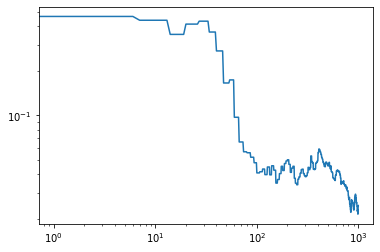

In [8]:
mse_list, brv_list = nash_vi_exploiter(env, itr=10000, epsilon = 0.5)
print(brv_list[-10:])
save_path = f'./data/NashVIExploiter/'
os.makedirs(save_path, exist_ok=True)
np.save(save_path+'data333.npy', brv_list)
# plt.plot(mse_list, label='mse')
plt.plot(brv_list+oracle_v_star, label='brv')
plt.xscale('log')
plt.yscale('log')
